In [1]:
import sys
sys.path.append('../algorithms')
sys.path.append('../datasets')

import torch

import matplotlib.pyplot as plt

from datasets import HSIDataset
from tvprior import TVPrior
from nabla import nabla

from torchvision import transforms
from math import sqrt


In [2]:
# Define device (default is "cpu")
device = "cuda"

# Define dtype
dtype = torch.float64

# Define random seed
seed = 42
torch.manual_seed(seed)

# Define data path
data_path = '/home/mhiriy/data/harvard.zarr'

# Signal to Noise Ratio
SNR = 15

In [3]:
# Load Datasets 
val_transform = transforms.Compose([transforms.ToTensor()]) # Transforms a the input data to torch tensors
dataset = HSIDataset(root_dir=data_path, split='train', transform=val_transform)

# Choose the index of the selected image in the dataset (ENMAP dataset contains 11 000 images)
idx = 17
x = dataset[idx].unsqueeze(0).to(device=device,dtype=dtype) # import image to device (cpu or gpu), sizes of x is [1,number of bands, width, height]
# Adds a small amount of white gaussian noise to the input HSI (sigma2 = 1e-4)
x += 1e-2*torch.rand_like(x, device=device, dtype=dtype)/torch.norm(x)

# Compute the panchromatic image from the ground truth HSI
panc = torch.sum(x, dim=1).unsqueeze(1)/x.shape[1]
grad_panc = nabla(panc)

# Adds noise to the input HSI
sigma2 = 10**(-SNR/10) * torch.norm(x, dim=[2,3])**2 / x.shape[2] / x.shape[3]
sigma2 = sigma2.unsqueeze(0).unsqueeze(1).reshape(1, sigma2.numel(), 1, 1)
sigma2 = sigma2.repeat(1, 1, x.shape[2], x.shape[3])

y = x + torch.sqrt(sigma2)*torch.randn_like(x, device=device, dtype=dtype)



In [ ]:
# Test square RGB image 
def to_rgb(x):
    rgb_gt = x.cpu().numpy()[0, ...].transpose(1, 2, 0)
    # rgb_gt = (rgb_gt - rgb_gt.min())/(rgb_gt.max()- rgb_gt.min())
    return rgb_gt

h,w,b = 128,128,3
x = torch.zeros((1,b,h,w), device=device, dtype=dtype)

size = 64
x[0,:, h//2 - size//2 : h//2 + size//2, w//2 - size//2 : w//2 + size//2] = 1

# Adds noise to the input HSI
SNR = 3
sigma2 = 10**(-SNR/10) * torch.norm(x)**2 / x.numel()


y = x + torch.sqrt(sigma2)*torch.randn_like(x, device=device, dtype=dtype)


plt.imshow(to_rgb(x))
plt.show()

plt.imshow(to_rgb(y))
plt.show()


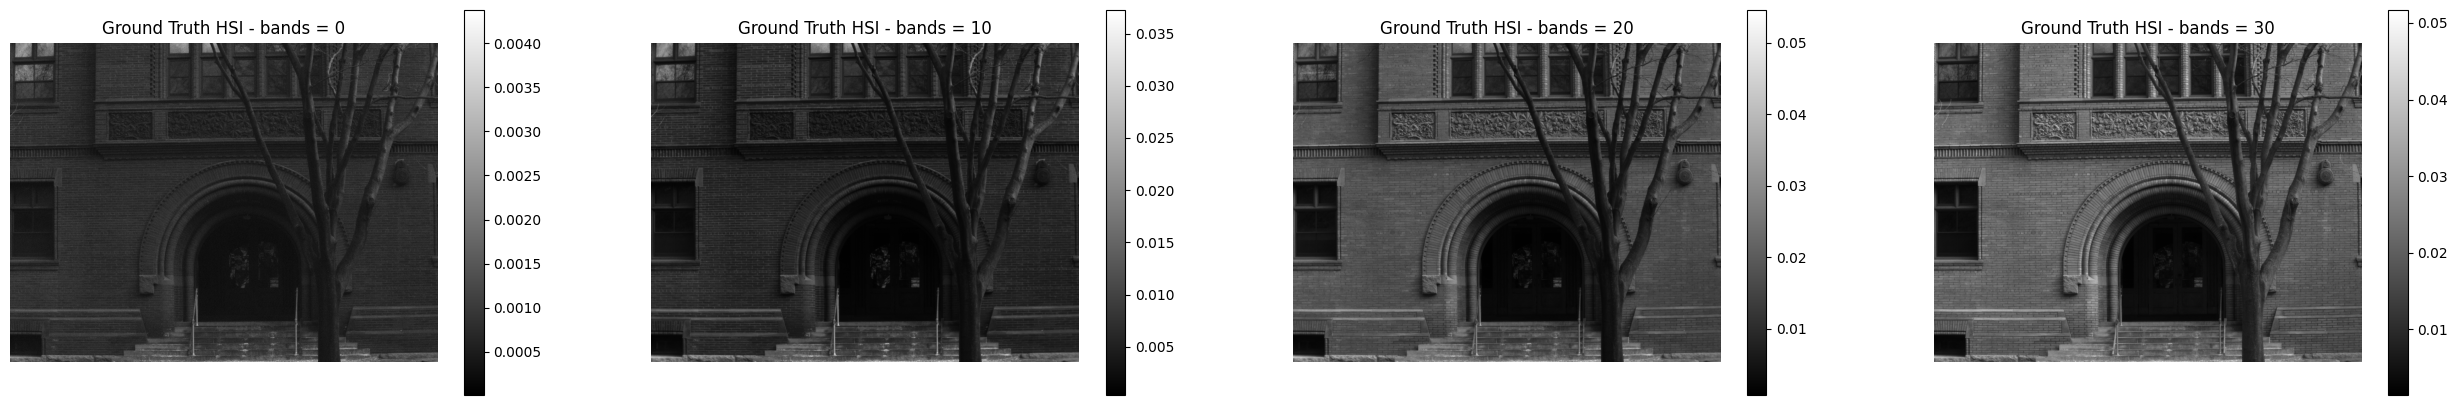

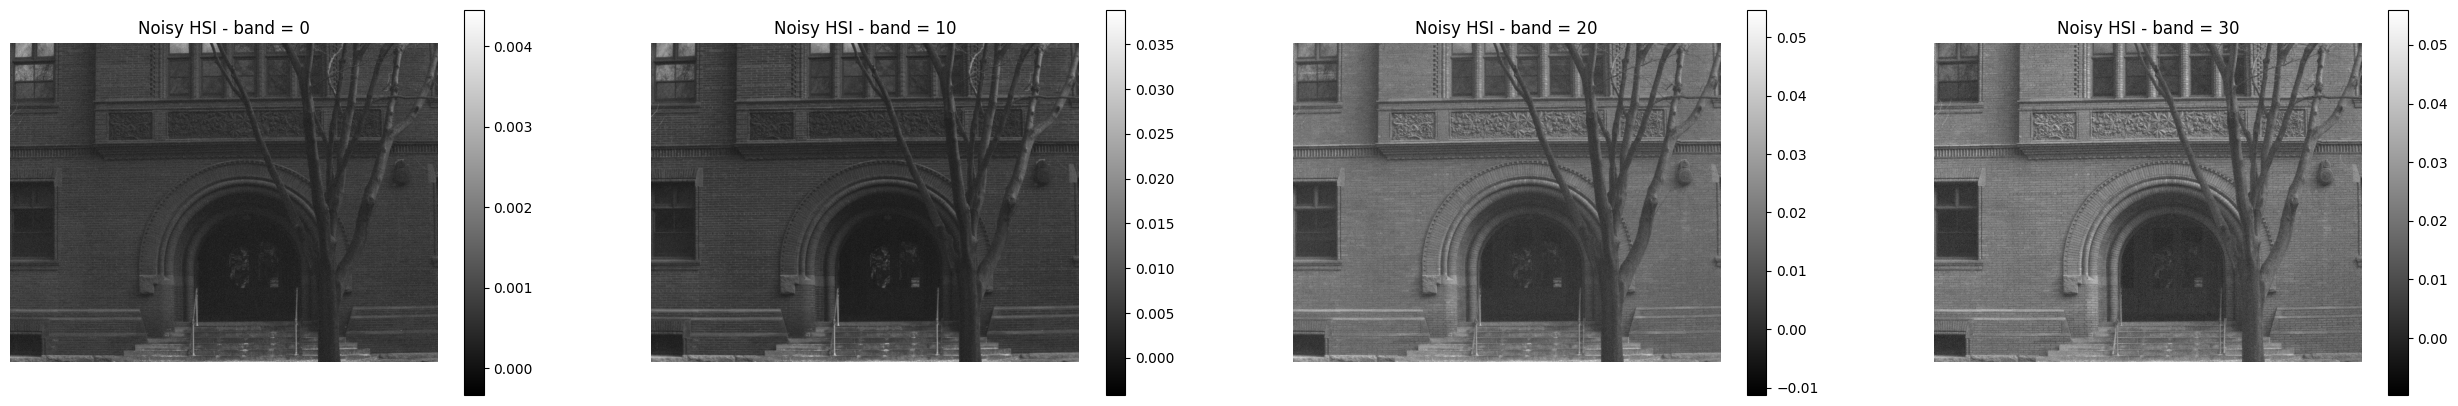

In [4]:
## Plot noisy and ground truth per band

cmap = 'gray'

band_index = [0, 10,20,30]

plt.figure(figsize=(40, 5))
for i, idx in enumerate(band_index):
    plt.subplot(151+i)
    plt.imshow(x[0, idx, ...].cpu().numpy(), cmap=cmap)
    plt.colorbar()
    plt.title('Ground Truth HSI - bands = {}'.format(idx))
    plt.axis('off')

plt.figure(figsize=(40, 5))
for i, idx in enumerate(band_index):
    plt.subplot(151+i)
    plt.imshow(y[0, idx, ...].cpu().numpy(), cmap=cmap)
    plt.colorbar()
    plt.title('Noisy HSI - band = {}'.format(idx))
    plt.axis('off')

plt.show()

In [ ]:
### Study effect of hyperparameters on convergence

# Define the solver parameters
params = {}

params['compute_L'] = {'nband': x.shape[1]}
params['K'] = {}
params['K_adjoint'] = {}
params['prox_sigma_g_conj'] = {}
params['prox_tau_f'] = {'y': y, 'sigma2': 1}
params['loss_fn'] = {}

# Define the TV prior parameters

niters = 1000
losses = {}

for gain in [2]:

    sigma = gain
    tau = 0.99/gain


    optim = TVPrior(max_iter=niters, lmbda=1e-1, theta=1, sigma=sigma, tau=tau)

    # Run the optimization
    x_est, loss = optim(y, init=None, verbose=False, params=params)

    losses[gain] = loss


plt.figure(figsize=(10,10))
for gain, loss in losses.items():
    plt.plot(loss, label='gain = {}'.format(gain))
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()




In [ ]:
### Study effect of acceleration on convergence

# Define the solver parameters
params = {}

params['compute_L'] = {'nband': x.shape[1]}
params['K'] = {}
params['K_adjoint'] = {}
params['prox_sigma_g_conj'] = {}
params['prox_tau_f'] = {'y': y, 'sigma2': 1}
params['loss_fn'] = {}

# Define the TV prior parameters

gain = 2
sigma = gain
tau = 0.99/gain

niters = 100
losses = {}

for gamma in [None, 1e-1, 5e-1]:



    if gamma is None:
        optim = TVPrior(max_iter=niters, lmbda=1e-2, theta=1, sigma=sigma, tau=tau)
    else:
        optim = TVPrior(max_iter=niters, lmbda=1e-2, theta=1, sigma=sigma, tau=tau, accelerate=True, gamma=gamma)

    # Run the optimization
    x_est, loss = optim(y, init=None, verbose=False, params=params)

    losses[gamma] = loss

# plot losses

plt.figure()
for gamma, loss in losses.items():
    plt.plot(loss, label='gamma = {}'.format(gamma))
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()




In [11]:
# Define the solver parameters
params = {}

params['compute_L'] = {'nband': x.shape[1]}
params['K'] = {}
params['K_adjoint'] = {}
params['prox_sigma_g_conj'] = {}
params['prox_tau_f'] = {'y': y, 'sigma2': 1}
params['loss_fn'] = {}

# Define the TV prior parameters
gain = 500

sigma = gain
tau = 0.99/gain


optim = TVPrior(max_iter=10000, lmbda=1e-3, theta=1, sigma=sigma, tau=tau)

# Run the optimization
x_est, loss, rel = optim(y, init=None, verbose=False, params=params)



  0%|          | 0/10000 [00:00<?, ?it/s]

In [12]:
x_est.shape

torch.Size([1, 31, 1040, 1392])

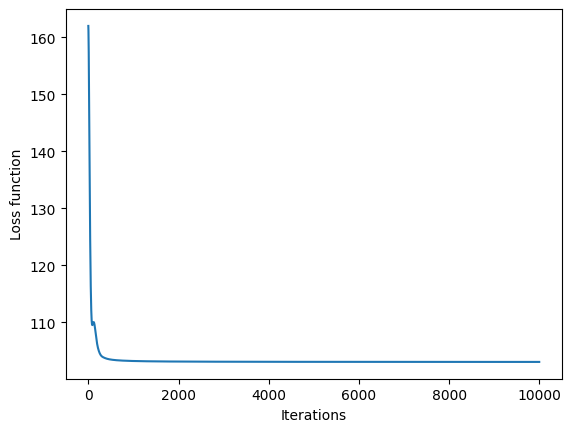

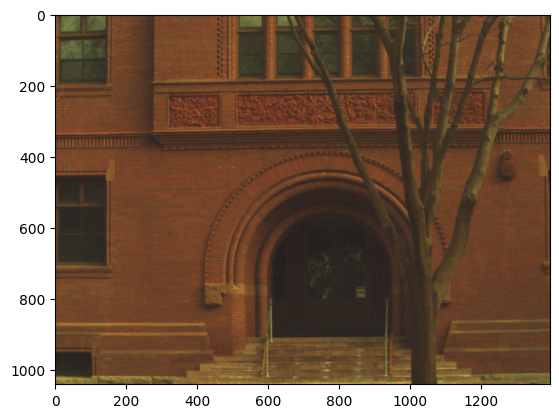

In [13]:
## Show loss function
def to_rgb(img, rgb):
    img_rgb = img[rgb, ...].cpu().numpy().transpose(1, 2, 0)
    img_rgb = (img_rgb - img_rgb.min()) / (img_rgb.max() - img_rgb.min())
    return img_rgb


import numpy as np
from PIL import Image

def save(im, path):
    im_rgb = Image.fromarray((im * 255).astype(np.uint8))
    im_rgb.save(path)


plt.figure()
plt.plot(loss)
plt.xlabel('Iterations')
plt.ylabel('Loss function')
plt.show()


plt.figure()
plt.imshow(to_rgb(x_est[0], dataset.rgb_index))

save(to_rgb(x_est[0], dataset.rgb_index), 'x_est.png')

In [ ]:
## Plot estimated, noisy and ground truth in RGB

def to_rgb(x):
    rgb_gt = x.cpu().numpy()[0, rgb_index, ...].transpose(1, 2, 0)
    rgb_gt = (rgb_gt - rgb_gt.min())/(rgb_gt.max()- rgb_gt.min())
    return rgb_gt

rgb_index = dataset.rgb_index

rgb_gt = to_rgb(x)
rgb_noisy = to_rgb(y)
rgb_estimated = to_rgb(x_est)

plt.figure(figsize=(10,30))

plt.subplot(131)
plt.imshow(rgb_noisy)
plt.title('Noisy Image')

plt.subplot(132)
plt.imshow(rgb_estimated)
plt.title('Estimated Image')

plt.subplot(133)
plt.imshow(rgb_gt)
plt.title('Ground truth Image')
plt.axis('off')


In [ ]:
## Plot estimated, noisy and ground truth per band

out = x_est
cmap = 'gray'

band_index = [0, 10,20,30]

plt.figure(figsize=(40, 5))
for i, idx in enumerate(band_index):
    plt.subplot(151+i)
    plt.imshow(x[0, idx, ...].cpu().numpy(), cmap=cmap)
    plt.colorbar()
    plt.title('Ground Truth HSI - bands = {}'.format(idx))
    plt.axis('off')

plt.figure(figsize=(40, 5))
for i, idx in enumerate(band_index):
    plt.subplot(151+i)
    plt.imshow(y[0, idx, ...].cpu().numpy(), cmap=cmap)
    plt.colorbar()
    plt.title('Noisy HSI - band = {}'.format(idx))
    plt.axis('off')

plt.figure(figsize=(40, 5))
for i, idx in enumerate(band_index):
    plt.subplot(151+i)
    plt.imshow(out[0, idx, ...].cpu().numpy(), cmap=cmap)
    plt.colorbar()
    plt.title('Denoised HSI - band = {}'.format(idx))
    plt.axis('off')

plt.show()

In [ ]:
## Plot eigenimages of estimated, noisy and ground truth per band

from datasets import get_eigenimages

z = get_eigenimages(x)
z_est = get_eigenimages(x_est)
z_noisy = get_eigenimages(y)

eigen_index = [1,3,5,7,9]

cmap = 'bone'

plt.figure(figsize=(30, 5))
for i, idx in enumerate(eigen_index):
    plt.subplot(151+i)
    plt.imshow(z[0, idx, ...].cpu().numpy(), cmap=cmap)
    plt.colorbar()
    plt.title('Eigenimage {}'.format(idx))
    plt.axis('off')

plt.figure(figsize=(30, 5))
for i, idx in enumerate(eigen_index):
    plt.subplot(151+i)
    plt.imshow(z_noisy[0, idx, ...].cpu().numpy(), cmap=cmap)
    plt.colorbar()
    plt.title('Noisy Eigenimage {}'.format(idx))
    plt.axis('off')

plt.figure(figsize=(30, 5))
for i, idx in enumerate(eigen_index):
    plt.subplot(151+i)
    plt.imshow(z_est[0, idx, ...].cpu().numpy(), cmap=cmap)
    plt.colorbar()
    plt.title('Denoised Eigenimage {}'.format(idx))
    plt.axis('off')

plt.show()